In [2]:
%matplotlib inline
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cython
from pathlib import Path
from os.path import join
from IPython.display import display_markdown
sns.set()

import platform

if platform.system() == 'Darwin':
    %config InlineBackend.figure_format = 'retina'


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
%%cython
cimport cython
cimport numpy as np
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def list_of_sequence_length(np.ndarray a, slippy=True, aside=None):
    if aside is not None:
        aside = aside.values
    cdef int curi = 0
    cdef int i
    cdef int actu = -1
    out = []
    for i in range(len(a)):
        if actu != a[i] and (a[i] != 0 or not slippy):
            if curi > 0:
                out.append([val, curi])
            curi = 0
            actu = a[i]
            if aside is not None:
                val = aside[i]
            else:
                val = actu
        if a[i] == actu and a[i] != 0:
            curi += 1
    if curi != 0:
        out.append([val, curi])
    return out


def sequence_length(a, slippy=True, aside=None):
    return list_of_sequence_length(a.values, slippy, aside)



def sequence_length_mean(a, slippy=True, aside=None):
    elems = sequence_length(a, slippy, aside)
    if elems:
        return np.mean(elems)
    else:
        return np.NaN


In [4]:
def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(path + '.gz', *args, **kwargs)
    except: 
        return pd.read_csv(path, *args, **kwargs)

# /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_1/rep00//analysis_log_1499.txt

fail with /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_1/rep00/../fit.txt
<class 'FileNotFoundError'> File b'/data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_1/rep00/../fit.txt' does not exist


# /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_2/rep00//analysis_log_1499.txt

fail with /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_2/rep00/../fit.txt
<class 'FileNotFoundError'> File b'/data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_2/rep00/../fit.txt' does not exist


# /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_3/rep00//analysis_log_1499.txt

fail with /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_3/rep00/../fit.txt
<class 'FileNotFoundError'> File b'/data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_3/rep00/../fit.txt' does not exist


# /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_4/rep00//analysis_log_1499.txt

fail with /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_4/rep00/../fit.txt
<class 'FileNotFoundError'> File b'/data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_4/rep00/../fit.txt' does not exist


# /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_5/rep00//analysis_log_1499.txt

fail with /data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_5/rep00/../fit.txt
<class 'FileNotFoundError'> File b'/data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_5/rep00/../fit.txt' does not exist


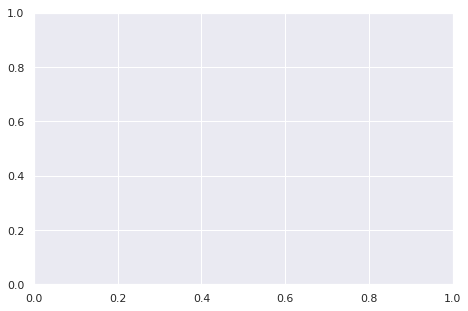

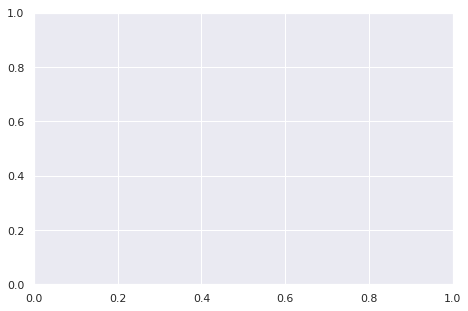

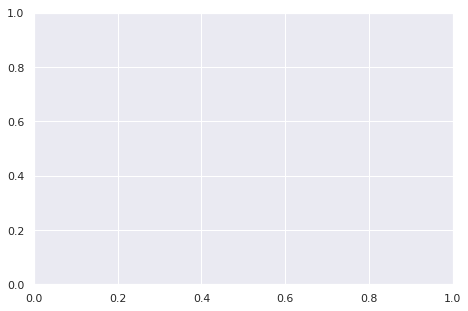

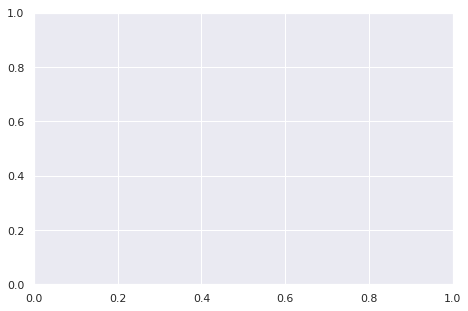

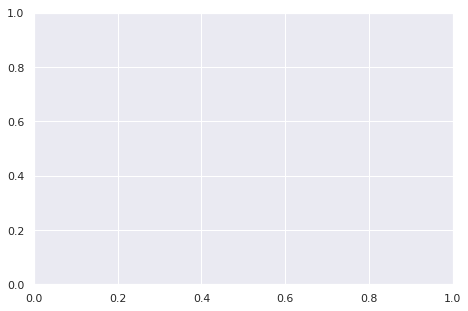

In [5]:
from itertools import product
force = False
runs = range(5)
for run, num in product(runs, [1499]):
    path = f"/data/logs/varyingsigma-fixcoop-control-2018-11-26-1808/0.5/run_{run+1}/rep{{}}/"
    
    path = path.format('00')
    slippy = True
    if not slippy and not 'tp' in path : 
        print("Attention, activer slippy ?????")
        
    logpath = f"{path}/analysis_log_{num}.txt"
    display_markdown("# " + logpath, raw=True)

    fail = False
    fig, ax = plt.subplots(figsize=(5*1.5,5))

    try:
        fitpath = Path(path) / "../fit.txt"
        fit = pd.read_csv(fitpath, delimiter="\t", names=['gen', 'min', 'q1', 'med', 'q3', 'max'])
    except Exception as e:
        print('fail with', fitpath)
        try:
            fit = read_csvx(str(fitpath), delimiter="\t")
        except Exception as e:
            print(type(e), e)
            continue
        
    else:
        print(fitpath)
    fit.plot(x='gen', y='q1', ax=ax)
    fit.plot(x='gen', y='med', ax=ax)
    fit.plot(x='gen', y='q3', ax=ax)
    ax.set_ylim(0, None)


    ax.axvline(num, label="observed gen", color="red")
    ax.legend()
    ax.set_title('fitness')
    plt.show(fig)

    logfile = join(path, f'logall_{num}.txt')
    i = 0
    ok = True
    to_format = '{' in logfile
    logs = []
    while ok:
        try:
            print(logfile.format(i))
            dat = read_csvx(logfile.format(i), delimiter="\t")
            dat["eval"] = i
            logs.append(dat)
        except Exception as e:
            print(type(e), e)
            ok = False
        else:
            i += 1
            ok = to_format
    try:
        if ('1p1' in path):
            log = pd.concat(logs).query('fake == 0 and id < 90').copy() # Fakes are removed from data
        else:
            log = pd.concat(logs).query('fake == 0').copy() # Fakes are removed from data
    except Exception as e:
        plt.show(fig)
        print("no data, continue")
        print(type(e), ':', e)
        continue
    fig, ax2 = plt.subplots(1, 1, figsize=(4, 5))
    sns.violinplot(data=log.query('2 <= nbOnOpp <= 2 and onOpp == 1'), x='nbOnOpp', y='curCoop', cut=0, ax=ax2, scale='count')
    ax2.set_ylabel("Investment played")
    ax2.set_xlabel("Number of partners")
    ax2.axhline(2.5, color="red")
    ax2.set_ylim(0, 10)
    plt.show(fig)
    
    
    try:
        df = read_csvx(logpath, delimiter="\t").query('ind < 90').copy()
    except Exception as e:
        print(type(e), e)
        continue

    df['trueoppCoop'] = np.where((df['oppId'] == 0), -2, df['oppCoop'])
    df['trueoppCoop'] = np.where((df['oppId'] > 0) & (df['oppNb'] == 0), -1, df['trueoppCoop'])
    #df['trueoppCoop'] = pd.Categorical(df['trueoppCoop'], categories=['cherche', 'seul'] + list(range(0, 11)), ordered=True)
    df['onOpp'] = np.where(df['oppId'] > 0, 1, 0)
    df['justarrived'] = df['onOpp'].diff() == 1

    #timespent = df.groupby(['ind', 'rep']).apply(lambda x : pd.DataFrame(sequence_length(x['oppId'], slippy, x['trueoppCoop']), columns=['trueoppCoop', 'time'])).reset_index().infer_objects()
    
    # Here, we take the total amount of time spent on each type of coop unit per rep
    timespent = df.groupby(['trueoppCoop', 'ind', 'rep'], as_index=False).count()
    timespent = timespent.groupby(['ind', 'trueoppCoop'], as_index=False).mean().copy()
    timespent['time'] = timespent['onOpp']
    
    
    fig, ax = plt.subplots(figsize=(15, 4))
    sns.violinplot(data=timespent.query('trueoppCoop >= 0'), x='trueoppCoop', y='time', cut=0, scale="width", inner="points", ax=ax)
    ax.set_ylim(0, 1500)

    #plt.ylim(0,500)
    plt.ylabel('Mean time on the object')
    plt.xlabel('investment of partner on the object');
    #plt.ylabel('')
    #plt.xlabel('');
    plt.show(fig)
    fig.savefig('partnerchoice.svg')

    fig, ax = plt.subplots(figsize=(16, 4))
    sns.barplot(data=timespent.query('trueoppCoop >= 0'), x='trueoppCoop', y='time', ax=ax)
    ax.set_xlabel("Investment of partner")
    ax.set_ylabel("time spent with the partner")
    plt.show(fig)


    df['truecoop'] = np.where(df['onOpp'], df['ownCoop'], np.nan)
    # df.loc[np.where(np.isnan(df['truecoop']))[0] + 1, 'truecoop'] = np.nan
        
    
    fig, ax = plt.subplots(figsize=(10, 5))
    #sns.violinplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).median(), cut=0, x='trueoppCoop', y='ownCoop', scale='count', inner='points')
    sns.stripplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).median(), x='trueoppCoop', y='truecoop')
    #sns.violinplot(data=df.query('onOpp > 0'), cut=0, x='trueoppCoop', y='ownCoop', scale='count')
    ax.axhline(2.5, label='ess')
    ax.set_title("[PartnerControl] Investissement median par individu en fonction de l'investissement de l'autre")
    ax.legend()
    ax.set_ylabel("$x$")
    ax.set_xlabel("$x_0$")
    ax.set_ylim(0, 10);
    plt.show(fig)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    #sns.violinplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).median(), cut=0, x='trueoppCoop', y='ownCoop', scale='count', inner='points')
    try:
        sns.stripplot(data=df.query('onOpp > 0').groupby(['trueoppCoop', 'ind'], as_index=False).median(), x='trueoppCoop', y='spite')
    except Exception as e:
        print(type(e), e)
    else:
        #sns.violinplot(data=df.query('onOpp > 0'), cut=0, x='trueoppCoop', y='ownCoop', scale='count')
        ax.axhline(2.5, label='ess')
        ax.set_title("[PartnerControl] Punition median par individu en fonction de l'investissement de l'autre")
        ax.legend()
        ax.set_ylabel("$x$")
        ax.set_xlabel("$x_0$")
        ax.set_ylim(0, None);
    finally:
        plt.show(fig)
    
    fig, ax = plt.subplots(figsize=(15, 4))
    df.query('ind == 1 and rep == 2')['truecoop'].plot(ax=ax, style='.')
    df.query('ind == 1 and rep == 2')['truecoop'].plot(ax=ax, style='--', alpha=0.7, c=sns.palettes.get_color_cycle()[0])
    ax.set_ylim(0, 10)
    plt.show(fig)

    if False:
        best = df.groupby('ind', as_index=False).mean()['truecoop'].nlargest(20).index
        worst = df.groupby('ind', as_index=False).mean()['truecoop'].nsmallest(20).index

        timespent.loc[np.where(timespent['ind'].isin(best))[0], 'good'] = 'Cooperateur'
        timespent.loc[np.where(timespent['ind'].isin(worst))[0], 'good'] = 'Egoiste'

        plt.figure(figsize=(11, 4))
        sns.violinplot(data=timespent, x='trueoppCoop', y='time', cut=0, scale='count', hue='good', split=True)
        plt.title("Temps passé sur un objet en fonction de la coopération du faux robot, temps moyen par individu")
        plt.ylabel("% temps sur un objet")
        plt.xlabel("$x_0$ : investissement du robot partenaire");
        plt.show()

In [5]:
################
#% CONF LOADER #
################

import os.path
medcooplist = []
num = 3499
conds = [
    ('classic', "/data/logs/fixcoop-sigma-tp-2018-12-10-1746/0/0/"),
    ('maxcoop50', "/data/logs/fixcoop-sigma-tp-2018-12-11-1740/0/0/")
        ]
for condname, catpath in conds:
    run = 1
    if (os.path.exists(os.path.join(catpath, "run_{run:02}/rep00/".format(run=run)))):
        path = os.path.join(catpath, "run_{run:02}/rep00/")
    else:
        path = os.path.join(catpath, "run_{run}/rep00/")
    print(path.format(run=run))
    while os.path.exists(path.format(run=run)):
        logfile = join(path.format(run=run), f'logall_{num}.txt')
        i = 0
        ok = True
        to_format = '{' in logfile
        logs = []
        while ok:
            try:
                dat = read_csvx(logfile.format(i), delimiter="\t", nrows=1_000_000)
                dat["eval"] = i
                logs.append(dat)
            except:
                ok = False
            else:
                i += 1
                ok = to_format
        try:
            log = pd.concat(logs).query('fake == 0').copy() # Fakes are removed from data
        except Exception as e:
            raise e
            plt.show(fig)
            print("no data, continue")
        med = log.query('nbOnOpp == 2 and onOpp > 0')['curCoop'].mean()
        print(run, ':', med)
        medcooplist.append({'run': condname,
                            'iter': run,
                            'medcoop': med})
        run += 1

/data/logs/fixcoop-sigma-tp-2018-12-10-1746/0/0/run_01/rep00/
1 : 4.297962370763507
2 : 1.9426671879162074
3 : 4.062742839696365
4 : 3.7442867769936106
5 : 3.619204236796973
6 : 3.7154504835409234
7 : 3.458210000000001
8 : 5.915092378091889
9 : 4.0135082550802235
10 : 4.676658820741425
11 : 1.9101089396522777
12 : 1.6209698501467928
13 : 4.7419267626525095
14 : 3.8386513481175872
15 : 3.9847090639403584
16 : 4.284071368974669
17 : 5.522371300603245
18 : 3.390836244551486
19 : 4.326726490926835
20 : 4.500139999999995
21 : 3.4491384260868823
22 : 5.07999120739385
23 : 6.577999827004979
24 : 4.3567900208739365
25 : 4.360620366868748
26 : 4.475627715780009
27 : 5.022618630204975
28 : 4.1198181691287825
29 : 3.5376175477473035
30 : 5.450604618937091
31 : 2.1512411982532336
32 : 2.226388981623636
/data/logs/fixcoop-sigma-tp-2018-12-11-1740/0/0/run_01/rep00/
1 : 4.4087099304360775
2 : 2.409320443246248
3 : 1.8327903335312787
4 : 4.8460921333271605
5 : 1.9490868252423075
6 : 4.6378113953874776

In [6]:
force = True
if force:
    try:
        del medcoop
    except NameError:
        pass
try:
    medcooptmp = pd.DataFrame(medcooplist)
    for condname in medcooptmp['run'].unique():
        if condname in medcoop['run'].unique():
            print(f'{condname} already in batch, abort')
        else:
            medcoop = medcoop.append(medcooptmp.query(f'run == "{condname}"'))
except:
    medcoop = pd.DataFrame(medcooplist)

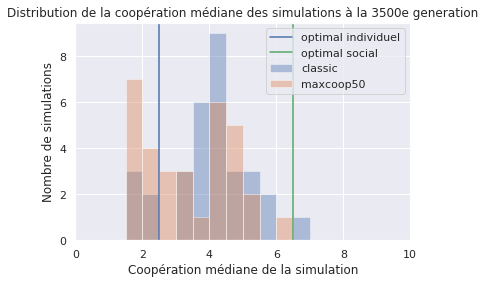

In [10]:
comps = [cond[0] for cond in conds[:2]]
for comp in comps:
    if not medcoop.query(f'run == "{comp}"').empty:
        #plt.figure()
        a = 5
        if 'bigb' in comp:
            b = 10
        else:
            b = 3
        ess = a/2
        so = a + b - b/2
        corrected = (medcoop.query(f'run == "{comp}"')['medcoop'] - ess) / (so - ess)
        corrected = medcoop.query(f'run == "{comp}"')['medcoop']
        sns.distplot(corrected, label=comp, norm_hist=False, hist=True, kde=False, bins=np.arange(0, 10, 0.5), kde_kws={'shade': True})
        #sns.distplot(medcoop['medcoop'], hist=True, kde=False, bins=None, kde_kws={'shade': True})
plt.axvline(ess, label="optimal individuel")
plt.axvline(so, c="g", label="optimal social")
plt.xlim(0, 10)
plt.ylabel("Nombre de simulations")
plt.xlabel(f"Coopération médiane de la simulation")
plt.title(f"Distribution de la coopération médiane des simulations à la {num+1}e generation")
plt.legend()
plt.show()

In [11]:
import scipy as sp
sp.stats.wilcoxon(medcoop.query(f'run == "{comps[0]}"')['medcoop'], medcoop.query(f'run == "{comps[1]}"')['medcoop'])

WilcoxonResult(statistic=151.0, pvalue=0.03460246283803436)

In [ ]:
plt.plot()